<a href="https://colab.research.google.com/github/Abhigyan-dev/CNN-Classifier/blob/main/Food_Track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Food Image Classifier** 

The aim of this project is to train a classifier so that it can identify/classify an input image into a food category.

There are total 61 different food items and we have to report for a given test set (in this case of size 484) the food item displayed in it.

We are given 9323 samples to train our classifier with.

The output of this code is a ```.csv``` file containing the label(representing the 61 food items) corresponding to each test case of the 484 test samples.

Dataset is available [here](https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021).

In [2]:
  %matplotlib inline

The classifier is trained using PyTorch framework hence its corresponding libraries are imported.


*   Torch - One of the main libraries of the PyTorch framework. Has many features for deep learning.
*   Torchvision - Helpful for transforming input data to tensors and batch them.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

Following two cells are steps to download dataset: 

In [4]:
!pip install aicrowd-cli

My API key(obtained from AIcrowd) is entered to connect to my account

In [5]:
API_KEY="0a66d79516da407987b630bf4deeac2b"
!aicrowd login --api-key $API_KEY
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

API Key valid
Saved API Key successfully!
train_images.zip: 100% 754M/754M [00:07<00:00, 104MB/s]
test_images.zip: 100% 33.9M/33.9M [00:00<00:00, 49.0MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 3.34MB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 777kB/s]


At this point we have the training and test images as zip file. We have to unzip them to get the ```.csv``` files.

In [6]:
!unzip train_images.zip
!unzip test_images.zip


Streaming output truncated to the last 5000 lines.
  inflating: train_images/22d805cf15.jpg  
  inflating: train_images/145896eed0.jpg  
  inflating: train_images/c468193dfd.jpg  
  inflating: train_images/7c6dccda37.jpg  
  inflating: train_images/c03811cd27.jpg  
  inflating: train_images/f04e23613b.jpg  
  inflating: train_images/d1cbbc1134.jpg  
  inflating: train_images/d762ff4fd3.jpg  
  inflating: train_images/1df8826db5.jpg  
  inflating: train_images/4f05c60d04.jpg  
  inflating: train_images/1b33d95837.jpg  
  inflating: train_images/fa3e225fe7.jpg  
  inflating: train_images/7bcd015a19.jpg  
  inflating: train_images/a413778c2b.jpg  
  inflating: train_images/4945972217.jpg  
  inflating: train_images/5245cffff8.jpg  
  inflating: train_images/6012b508f4.jpg  
  inflating: train_images/8bf820b404.jpg  
  inflating: train_images/f75497ad34.jpg  
  inflating: train_images/7b80dad7a0.jpg  
  inflating: train_images/2b7d946341.jpg  
  inflating: train_images/f8278624bb.jpg  
  i

In [7]:
#checking the extracted files
%ls
%pwd

sample_data/  test_images/     train.csv      train_images.zip
test.csv      test_images.zip  train_images/


'/content'

A class called CustomImageDataset is created.
It will be called to obtain the trainset and testset

In [14]:
import os
import pandas as pd
import matplotlib.image as mpimg
import numpy as np


class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        # different transforms for train and test sets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image= mpimg.imread(img_path)
        label=self.img_labels.iloc[idx,0]
        
        if np.shape(self.img_labels)[1]==2:
         label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Now we have to define transform available in torchvision library. These transforms the training and test set by converting them to tensors, resizing and normalizing them. 

*On the training set, we also perform horizontal flips on images so that we can create diverse samples and train the classifier so that it can understand flipped images as well. Similarly numerous other transforms like color jitter, center crop etc... can also be added*

After definign transforms, CustomImageDataset is called to obtain trainset and testset.

In [15]:
batch_size=100

#transform for training data
transformTrain = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128,128)),
     transforms.RandomHorizontalFlip(0.5), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#trainset from train.csv
trainset = CustomImageDataset(annotations_file='train.csv',
                                    img_dir='train_images/',transform=transformTrain)


#transform for test data
transformTest = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128,128)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#test set from test.csv
testset= CustomImageDataset(annotations_file='test.csv',
                                    img_dir='test_images/',transform=transformTest)


img,label = trainset[0] 
print(img.shape) #dimension of each image

print("training set samples: ",len(trainset))
print("test set samples: ",len(testset))

torch.Size([3, 128, 128])
training set samples:  9323
test set samples:  484


A tuple called classes is created. It contains a list of all the categories of 
food items that we have in the training and test set.

This list is obtained from the AIcrowd site.      

In [16]:
#Classes obtained from given list on dataset_info.txt

classes=('BG',                                                
'water',                                             
'pizza-margherita-baked',                            
'broccoli',                                          
'salad-leaf-salad-green',                            
'zucchini',                                          
'egg',                                               
'butter',                                            
'bread-white',                                       
'apple',                                             
 'dark-chocolate',                                    
 'white-coffee-with-caffeine',                        
 'sweet-pepper',                                      
 'mixed-salad-chopped-without-sauce',                 
 'tomato-sauce',                                      
 'bread-wholemeal',                                   
 'coffee-with-caffeine',                              
 'cucumber',                                          
 'cheese',                                            
 'pasta-spaghetti',                                   
 'rice',                                              
 'salmon',                                            
 'carrot',                                            
 'onion',                                             
 'mixed-vegetables',                                  
 'espresso-with-caffeine',                            
 'banana',                                            
 'strawberries',                                      
 'mayonnaise',                                        
 'almonds',                                           
 'wine-white',                                        
 'hard-cheese',                                       
 'ham-raw',                                           
 'tomato',                                            
 'french-beans',                                      
 'mandarine',                                         
 'wine-red',                                          
 'potatoes-steamed',                                  
 'croissant',                                         
 'salami',                                            
 'boisson-au-glucose-50g',                            
 'biscuits',                                          
 'corn',                                              
 'leaf-spinach',                                      
 'jam',                                               
 'tea-green',                                         
 'chips-french-fries',                                
 'parmesan',                                          
 'beer',                                              
 'avocado',                                           
 'bread-french-white-flour',                          
 'chicken',                                           
 'soft-cheese',                                       
 'tea',                                               
 'sauce-savoury',                                     
 'honey',                                             
 'bread-whole-wheat',                                 
 'bread-sourdough',                                   
 'gruyere',                                           
 'pickle',                                            
 'mixed-nuts',                                        
 'water-mineral' 
)

Now we want to create a validation set which will be used to test and improve our classifier. validation set is created from the training set itself. 

Hence to find the validation set, ```make_split``` funciton is created. This function randomly picks up some indices from the training set and the values at those indices now belong to the validation set. The size of validation set is chosen by us.
In my case the size of the validation set is 932 (=9323 *0.1)

In [17]:
import numpy as np

#function for creating validation set indices by splitting given training set's indices

def make_split(n,val_percent):
  ind = list(range(n))
  np.random.shuffle(ind)  
  split = int(np.floor(val_percent*n))
  return ind[split:],ind[:split]

In [18]:
train_ind,valid_ind = make_split(len(trainset),0.1) 
print('length of modified training set : ',len(train_ind))
print('length of validation set : ',len(valid_ind)) 

length of modified training set :  8391
length of validation set :  932


Now we use the DataLoader to transform the training, validation and test set into batches of required sizes. To shuffle the training set and validation set, SubsetRandomSampler is used so it separately selects random batches for training and validation provided we give it their indices.

Converting our data into batches means that in each epoch we will be loading ```batch_size``` number of training samples in each pass.

It is important to convert our data in batches because when we train our classifier, if we load complete training set in each epoch, it might not fit into machine's memory.  Hence we only load some data in each epoch, which we do by batching. 

In [19]:
from torch.utils.data import SubsetRandomSampler,DataLoader

#Training sampler and dataloader
train_sampler=SubsetRandomSampler(train_ind)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler= train_sampler , num_workers=0)

#validation sampler and dataloader
valid_sampler=SubsetRandomSampler(valid_ind)
validloader = DataLoader(trainset, batch_size=batch_size, sampler= valid_sampler , num_workers=0)

testloader = DataLoader(testset, batch_size=batch_size, num_workers=0)

Displaying a batch of our training set along with their labels.

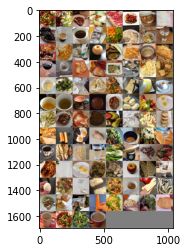

In [20]:
#display the images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))


**Defining the Classifier**

The CNN architecture is given below :
* 16 3x3 Filters
* ReLu 
* Max Pool 2x2
* 32 3x3 Filters
* ReLu 
* Max Pool 2x2
* 64 3x3 Filters
* ReLu 
* Max Pool 2x2
* Fully Connected layer 1 
* Fully Connected layer 2


This is how the CNN converts the image to output:
* Input=3x128x128
* After 1st Filter = 16x128x128 ,then ReLu
* After pooling = 16x64x64
* After 2nd Filter = 32x64x64 ,then ReLu
* After pooling = 32x32x32
* After 3rt Filter = 64x32x32 ,then ReLu
* After pooling = 64x16x16
* Linear layer = 64x16x16 to 500
* Linear layer = 500 to 100

In [21]:
#defining a  NN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(3,16,3,padding=1)
    self.conv2= nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)  
    self.pool=nn.MaxPool2d(2,2) 
    self.fc1=nn.Linear(64*16*16,500) 
    self.fc2=nn.Linear(500,100)
    self.dropout=nn.Dropout(0.25)

  def forward(self,x):

    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=x.view(-1,64*16*16)
    x=self.dropout(x)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x



avocado salad-leaf-salad-green butter cucumber butter tomato-sauce pizza-margherita-baked gruyere bread-wholemeal espresso-with-caffeine   tea butter salad-leaf-salad-green   egg water water bread-wholemeal chips-french-fries   tea apple mixed-vegetables chips-french-fries water pasta-spaghetti wine-red water bread-wholemeal croissant sweet-pepper wine-white  rice bread-french-white-flour white-coffee-with-caffeine mixed-salad-chopped-without-sauce water bread-white pickle butter banana   egg   tea   tea coffee-with-caffeine coffee-with-caffeine mixed-vegetables bread-white tomato   egg cucumber butter butter bread-wholemeal pickle water mixed-salad-chopped-without-sauce bread-white cheese carrot   egg bread-wholemeal zucchini white-coffee-with-caffeine leaf-spinach water coffee-with-caffeine tomato bread-sourdough water salad-leaf-salad-green banana mixed-nuts tomato sauce-savoury water   egg bread-wholemeal bread-white apple bread-wholemeal water   egg salad-leaf-salad-green water bu

Here we define a model called ```first_net```.
Criterion and Optimizer are also defined which will be used later to train the network.

In [22]:
#initialising model
model=Net()

import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

This is the main part. Here we train the model for ```epoch_cnt``` epochs.

In each epoch, the model is first trained on the whole training set in batches and then it is evaulated on the validation set. This is done so that we can monitor our model and also if after some epochs our model begins to overfit on the training set, it will start to perform poorly on the validation set, so we only save the model until it is performing well, using the ```if``` condition at the last.

In [ ]:
epoch_cnt = 5
LOSS = np.Inf

for epoch in range(epoch_cnt):     
  print(f"Running for epoch: {epoch+1}")

  val_loss = 0
  train_loss = 0

  #training
  print("training model...")
  model.train() # define to PyTorch that we are going to train the model
  for data in trainloader:
    inputs,lbl =data  # In this case the training set has labels as strings
    labels=[]
    #print(inputs.size())
    i=0
    for i in lbl:
      labels.append(classes.index(i))  # here we find the index of corresponding string in our class
      
    labels=torch.tensor(labels)  #convert lables to tensor
    optimizer.zero_grad()       
    output=model(inputs)
    loss=criterion(output,labels)
    loss.backward() 
    optimizer.step()    
    train_loss = train_loss + loss.item()
  
  #validation
  print("evaluating model...")
  model.eval()  # define to PyTorch that we are going to evaluate the model
  for data in validloader:
    inputs,lbl =data
    labels=[]
    i=0 
    for i in lbl:
      labels.append(classes.index(i))
    
    labels=torch.tensor(labels)
    output=model(inputs)
    loss = criterion(output,labels)
    val_loss = val_loss + loss.item()

  #finding the avg losses
  train_loss=train_loss/len(trainloader.sampler)
  val_loss=val_loss/len(validloader.sampler)
  
  #displaying the losses
  print(f"Epoch is : {epoch+1} \t Training Loss is : {train_loss}  \t Validation Loss is : {val_loss} \n")


  if val_loss<=LOSS:
    torch.save(model.state_dict(),'FoodImage_CNN.pth')
    LOSS=val_loss

Running for epoch: 1
training model...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


evaluating model...
Epoch is : 1 	 Training Loss is : 0.04033870933422697  	 Validation Loss is : 0.04114400496298663 

Running for epoch: 2
training model...
evaluating model...
Epoch is : 2 	 Training Loss is : 0.03641349572331839  	 Validation Loss is : 0.03731340016418261 

Running for epoch: 3
training model...


The trained model is loaded

In [ ]:
first_net = Net()
first_net.load_state_dict(torch.load("FoodImage_CNN.pth"))

Now we will find the accuracy of the model by testing it on the validation set

For a particular batch, the class with highest probability is selected.

In [ ]:
correct = total = 0

with torch.no_grad():
    for data in validloader:
        images,lbl=data
        labels=[]
        for i in lbl:
          labels.append(classes.index(i)) 

        labels = torch.tensor(labels) # convert targets to tensor

        # calculate outputs by running images through the network   
        outputs = first_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images(from validation set): %d %%' % (100 * correct / total))


This is the final part where we find the labels for the test set.

In [ ]:
ans = []

with torch.no_grad():
    for data in testloader:
        images,labels=data
        i = 0

        # calculate outputs by running images through the network
        outputs = first_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
      
        for elem in predicted:      #iterating over all the maximum predictions of the selected batch
          ans.append([labels[i], classes[(elem)]])
          i += 1

Having obtained the ans list which contains the labels of test set, we have to save it as a ```.csv``` file and add a header to it as suggested in the submission format. It is done below. 

Remark: the file contains the image name as well as label, hence two headers

In [ ]:
hl = ['id','ClassName']
output = pd.DataFrame(ans)
output.to_csv('./submission.csv', header = hl,index=False, sep=',')  #save output to file 

Finally the ```.csv``` file is submitted to AIcrowd 

In [ ]:
#!aicrowd submission create -c chunin-exams-food-track-cv-2021 -f submission.csv